In [1]:
"""
    Dataset (Bangla ( Bengali ) sentiment analysis classification benchmark dataset corpus) : https://data.mendeley.com/datasets/p6zc7krs37/4
"""
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from matplotlib import pyplot
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
import pandas as pd
import string
import numpy as np
import numpy as np
import pandas as pd
from gensim.models.word2vec import Word2Vec
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.layers import *
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import *
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import PorterStemmer
from sklearn import preprocessing
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, LearningRateScheduler

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1660, compute capability 7.5


In [2]:
# Loading Bangla ( Bengali ) sentiment analysis classification benchmark dataset
positive_sentences = []
f = open('../datasets/all_positive_8500.txt','r', encoding = 'utf-8')
for line in f:
    positive_sentences.append(line.strip())

negative_sentences = []
f = open('../datasets/all_negative_3307.txt','r', encoding = 'utf-8')
for line in f:
    negative_sentences.append(line.strip())
    
print(len(positive_sentences), 'positive sentences')
print(len(negative_sentences), 'negative sentences')

import random
random.shuffle(positive_sentences)

for i in range(len(positive_sentences)-len(negative_sentences)):
    positive_sentences.pop(0)

print(len(positive_sentences), 'positive sentences')
print(len(negative_sentences), 'negative sentences')


y_pos = [1 for i in range(len(positive_sentences))]
y_neg = [0 for i in range(len(negative_sentences))]

X = positive_sentences + negative_sentences
y = y_pos + y_neg

8500 positive sentences
3307 negative sentences
3307 positive sentences
3307 negative sentences


In [3]:
w2v_model = Word2Vec.load("word2vec.model")
words = list(w2v_model.wv.index_to_key)
vocab_size = len(words)
print(vocab_size)

229077


In [4]:
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)
X_train_val = X_train
y_train_val = y_train

y_train_val_e = to_categorical(y_train_val)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_val_e, test_size=0.2, random_state=1, stratify=y_train_val_e)



In [5]:
from tensorflow.keras.layers import Embedding
def gensim_to_keras_embedding(model, train_embeddings=False):
    """Get a Keras 'Embedding' layer with weights set from Word2Vec model's learned word embeddings.

    Parameters
    ----------
    train_embeddings : bool
        If False, the returned weights are frozen and stopped from being updated.
        If True, the weights can / will be further updated in Keras.

    Returns
    -------
    `keras.layers.Embedding`
        Embedding layer, to be used as input to deeper network layers.

    """
    keyed_vectors = model.wv  # structure holding the result of training
    weights = keyed_vectors.vectors  # vectors themselves, a 2D numpy array    
    index_to_key = keyed_vectors.index_to_key  # which row in `weights` corresponds to which word?

    layer = Embedding(
        input_dim=weights.shape[0],
        output_dim=weights.shape[1],
        weights=[weights],
        trainable=train_embeddings,
    )
    return layer

In [6]:
def nlp_cnn(w2v):
    inputs = Input(shape=(X_train[0].shape[-1],))

    embedding_layer = gensim_to_keras_embedding(w2v)
    
    embedding_layer = embedding_layer(inputs)

    conv = Conv1D(600, 3, padding='same', activation='relu')(embedding_layer)
    conv = BatchNormalization()(conv)
    conv = MaxPool1D(pool_size=(2))(conv)

    conv = Conv1D(800, 3, padding='same', activation='relu')(conv)
    conv = BatchNormalization()(conv)
    conv = MaxPool1D(pool_size=(2))(conv)
    
    conv = Conv1D(1000, 3, padding='same', activation='relu')(conv)
    conv = BatchNormalization()(conv)
    conv = MaxPool1D(pool_size=(2))(conv)

    conv = Conv1D(1200, 3, padding='same', activation='relu')(conv)
    conv = BatchNormalization()(conv)
    
    output = GlobalAveragePooling1D()(conv)

    output = Dense(units=1200, activation='relu')(output)
    output = Dropout(0.5)(output)
    output = Dense(units=600, activation='relu')(output)
    output = Dropout(0.5)(output)
    output = Dense(units=300, activation='relu')(output)
    output = Dropout(0.5)(output)
    output = Dense(units=100, activation='relu')(output)
    output = Dense(units=2, activation='sigmoid')(output)
    
    model = Model(inputs, output)
    return model


model = nlp_cnn(w2v_model)



checkpoint = ModelCheckpoint('./model1.h5', save_freq="epoch",  verbose=1, monitor='val_accuracy', save_best_only=True,
    save_weights_only=False)

metrics = ['accuracy']
optimizer = Adam(0.0001)
model.compile(optimizer = optimizer, loss='binary_crossentropy', metrics=metrics)
model.summary()
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val), callbacks=[checkpoint])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 228)]             0         
                                                                 
 embedding (Embedding)       (None, 228, 300)          68723100  
                                                                 
 conv1d (Conv1D)             (None, 228, 600)          540600    
                                                                 
 batch_normalization (BatchN  (None, 228, 600)         2400      
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 114, 600)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 114, 800)          144080

132/133 [============================>.] - ETA: 0s - loss: 0.0399 - accuracy: 0.9865
Epoch 16: val_accuracy improved from 0.82625 to 0.85836, saving model to .\model1.h5
133/133 [==============================] - 10s 79ms/step - loss: 0.0398 - accuracy: 0.9865 - val_loss: 0.4813 - val_accuracy: 0.8584
Epoch 17/30
132/133 [============================>.] - ETA: 0s - loss: 0.0089 - accuracy: 0.9969
Epoch 17: val_accuracy did not improve from 0.85836
133/133 [==============================] - 9s 69ms/step - loss: 0.0089 - accuracy: 0.9969 - val_loss: 31.0729 - val_accuracy: 0.5014
Epoch 18/30
132/133 [============================>.] - ETA: 0s - loss: 0.0185 - accuracy: 0.9938
Epoch 18: val_accuracy did not improve from 0.85836
133/133 [==============================] - 9s 70ms/step - loss: 0.0185 - accuracy: 0.9939 - val_loss: 33.3634 - val_accuracy: 0.4995
Epoch 19/30
132/133 [============================>.] - ETA: 0s - loss: 0.0225 - accuracy: 0.9922
Epoch 19: val_accuracy did not impro

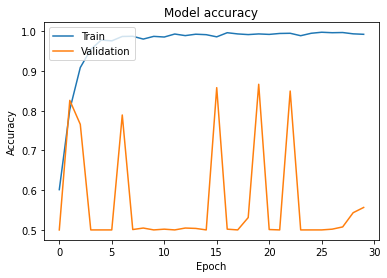

In [7]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [8]:
model = load_model('./model1.h5')
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)

42/42 [==============================] - 1s 18ms/step


In [9]:
from sklearn.metrics import classification_report, accuracy_score
print("CLASSIFICATION REPORT OF CNN")
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

CLASSIFICATION REPORT OF CNN
              precision    recall  f1-score   support

           0       0.83      0.92      0.87       661
           1       0.91      0.81      0.86       662

    accuracy                           0.87      1323
   macro avg       0.87      0.87      0.87      1323
weighted avg       0.87      0.87      0.87      1323

0.8654572940287226


In [10]:
for i, layer in enumerate(model.layers):
    print(layer.name, i)
f = Model(model.input, model.layers[13].output)
fe_train_val = f.predict(X_train_val)
fe_test = f.predict(X_test)


def flatten_features(x):
    x_flatten = []
    for f in x:
        f = f.flatten()
        x_flatten.append(f)
    x_flatten = np.array(x_flatten)
    return x_flatten


input_1 0
embedding 1
conv1d 2
batch_normalization 3
max_pooling1d 4
conv1d_1 5
batch_normalization_1 6
max_pooling1d_1 7
conv1d_2 8
batch_normalization_2 9
max_pooling1d_2 10
conv1d_3 11
batch_normalization_3 12
global_average_pooling1d 13
dense 14
dropout 15
dense_1 16
dropout_1 17
dense_2 18
dropout_2 19
dense_3 20
dense_4 21
42/42 [==============================] - 1s 14ms/step


In [11]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()

f_train_val = flatten_features(fe_train_val) # Doesn't put any effect if flatten/global average pooling used
f_test = flatten_features(fe_test)

# f_train_val = scaler.fit_transform(fe_train_val)
# f_test = scaler.fit_transform(fe_test)

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
k_range = list(range(1, 50))
param_grid = dict(n_neighbors=k_range)
grid = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', return_train_score=True,verbose=10)
grid_search=grid.fit(f_train_val, y_train_val)
print(grid_search.best_params_)

Fitting 5 folds for each of 49 candidates, totalling 245 fits
[CV 1/5; 1/49] START n_neighbors=1..............................................
[CV 1/5; 1/49] END n_neighbors=1;, score=(train=1.000, test=0.959) total time=   0.1s
[CV 2/5; 1/49] START n_neighbors=1..............................................
[CV 2/5; 1/49] END n_neighbors=1;, score=(train=1.000, test=0.960) total time=   0.1s
[CV 3/5; 1/49] START n_neighbors=1..............................................
[CV 3/5; 1/49] END n_neighbors=1;, score=(train=1.000, test=0.967) total time=   0.1s
[CV 4/5; 1/49] START n_neighbors=1..............................................
[CV 4/5; 1/49] END n_neighbors=1;, score=(train=1.000, test=0.970) total time=   0.1s
[CV 5/5; 1/49] START n_neighbors=1..............................................
[CV 5/5; 1/49] END n_neighbors=1;, score=(train=1.000, test=0.959) total time=   0.1s
[CV 1/5; 2/49] START n_neighbors=2..............................................
[CV 1/5; 2/49] END n_n

[CV 5/5; 10/49] END n_neighbors=10;, score=(train=0.975, test=0.973) total time=   0.1s
[CV 1/5; 11/49] START n_neighbors=11............................................
[CV 1/5; 11/49] END n_neighbors=11;, score=(train=0.975, test=0.971) total time=   0.1s
[CV 2/5; 11/49] START n_neighbors=11............................................
[CV 2/5; 11/49] END n_neighbors=11;, score=(train=0.978, test=0.965) total time=   0.1s
[CV 3/5; 11/49] START n_neighbors=11............................................
[CV 3/5; 11/49] END n_neighbors=11;, score=(train=0.976, test=0.972) total time=   0.1s
[CV 4/5; 11/49] START n_neighbors=11............................................
[CV 4/5; 11/49] END n_neighbors=11;, score=(train=0.974, test=0.981) total time=   0.1s
[CV 5/5; 11/49] START n_neighbors=11............................................
[CV 5/5; 11/49] END n_neighbors=11;, score=(train=0.975, test=0.974) total time=   0.1s
[CV 1/5; 12/49] START n_neighbors=12...............................

[CV 4/5; 20/49] END n_neighbors=20;, score=(train=0.973, test=0.979) total time=   0.1s
[CV 5/5; 20/49] START n_neighbors=20............................................
[CV 5/5; 20/49] END n_neighbors=20;, score=(train=0.973, test=0.974) total time=   0.1s
[CV 1/5; 21/49] START n_neighbors=21............................................
[CV 1/5; 21/49] END n_neighbors=21;, score=(train=0.974, test=0.972) total time=   0.1s
[CV 2/5; 21/49] START n_neighbors=21............................................
[CV 2/5; 21/49] END n_neighbors=21;, score=(train=0.977, test=0.966) total time=   0.1s
[CV 3/5; 21/49] START n_neighbors=21............................................
[CV 3/5; 21/49] END n_neighbors=21;, score=(train=0.975, test=0.974) total time=   0.1s
[CV 4/5; 21/49] START n_neighbors=21............................................
[CV 4/5; 21/49] END n_neighbors=21;, score=(train=0.973, test=0.981) total time=   0.1s
[CV 5/5; 21/49] START n_neighbors=21...............................

[CV 3/5; 30/49] END n_neighbors=30;, score=(train=0.974, test=0.973) total time=   0.1s
[CV 4/5; 30/49] START n_neighbors=30............................................
[CV 4/5; 30/49] END n_neighbors=30;, score=(train=0.972, test=0.982) total time=   0.1s
[CV 5/5; 30/49] START n_neighbors=30............................................
[CV 5/5; 30/49] END n_neighbors=30;, score=(train=0.974, test=0.973) total time=   0.1s
[CV 1/5; 31/49] START n_neighbors=31............................................
[CV 1/5; 31/49] END n_neighbors=31;, score=(train=0.975, test=0.973) total time=   0.2s
[CV 2/5; 31/49] START n_neighbors=31............................................
[CV 2/5; 31/49] END n_neighbors=31;, score=(train=0.977, test=0.965) total time=   0.1s
[CV 3/5; 31/49] START n_neighbors=31............................................
[CV 3/5; 31/49] END n_neighbors=31;, score=(train=0.975, test=0.974) total time=   0.1s
[CV 4/5; 31/49] START n_neighbors=31...............................

[CV 2/5; 40/49] END n_neighbors=40;, score=(train=0.976, test=0.965) total time=   0.1s
[CV 3/5; 40/49] START n_neighbors=40............................................
[CV 3/5; 40/49] END n_neighbors=40;, score=(train=0.974, test=0.973) total time=   0.1s
[CV 4/5; 40/49] START n_neighbors=40............................................
[CV 4/5; 40/49] END n_neighbors=40;, score=(train=0.970, test=0.981) total time=   0.1s
[CV 5/5; 40/49] START n_neighbors=40............................................
[CV 5/5; 40/49] END n_neighbors=40;, score=(train=0.973, test=0.974) total time=   0.1s
[CV 1/5; 41/49] START n_neighbors=41............................................
[CV 1/5; 41/49] END n_neighbors=41;, score=(train=0.974, test=0.970) total time=   0.1s
[CV 2/5; 41/49] START n_neighbors=41............................................
[CV 2/5; 41/49] END n_neighbors=41;, score=(train=0.976, test=0.966) total time=   0.1s
[CV 3/5; 41/49] START n_neighbors=41...............................

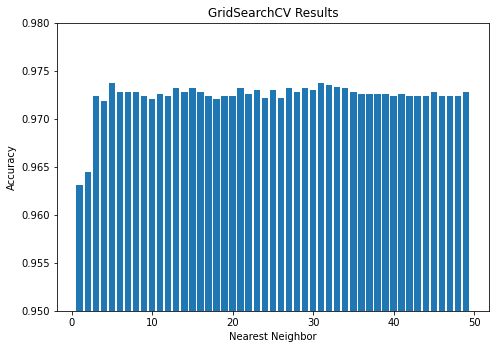

In [13]:
neighbors = []
l = []
for i, p in enumerate(grid.cv_results_['mean_test_score']):
    neighbors.append({'neighbor': i+1, 'score': p})
    l.append(i+1)

neighbors.sort(key=lambda x: x['score'], reverse=True)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(l,grid.cv_results_['mean_test_score'])
ax.set_ylim([0.95, 0.98])
plt.title('GridSearchCV Results')
plt.ylabel('Accuracy')
plt.xlabel('Nearest Neighbor')
plt.show()

In [14]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=neighbors[0]['neighbor'])
knn.fit(f_train_val, y_train_val)
preds = knn.predict(f_test)
preds_proba = knn.predict_proba(f_test)
print(classification_report(y_test, preds))
print("KNN", accuracy_score(y_test, preds))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88       661
           1       0.90      0.83      0.87       662

    accuracy                           0.87      1323
   macro avg       0.87      0.87      0.87      1323
weighted avg       0.87      0.87      0.87      1323

KNN 0.8707482993197279


In [15]:
from sklearn.ensemble import VotingClassifier, BaggingClassifier
knn1 = KNeighborsClassifier(n_neighbors=neighbors[0]['neighbor'])

knn2 = KNeighborsClassifier(n_neighbors=neighbors[1]['neighbor'])

knn3 = KNeighborsClassifier(n_neighbors=neighbors[2]['neighbor'])

knn4 = KNeighborsClassifier(n_neighbors=neighbors[3]['neighbor'])

knn5 = KNeighborsClassifier(n_neighbors=neighbors[4]['neighbor'])

eclf1 = VotingClassifier(estimators=[('knn1', knn1),
                                     ('knn2', knn2),
                                    ('knn3', knn3),
                                     ('knn4', knn4),
                                     ('knn5', knn5),
                                    ], voting='soft')

eclf1.fit(f_train_val, y_train_val)

preds = eclf1.predict(f_test)

In [16]:
print(classification_report(y_test, preds))
print("KNN VOTING", accuracy_score(y_test, preds))

              precision    recall  f1-score   support

           0       0.85      0.92      0.88       661
           1       0.91      0.84      0.87       662

    accuracy                           0.88      1323
   macro avg       0.88      0.88      0.88      1323
weighted avg       0.88      0.88      0.88      1323

KNN VOTING 0.8767951625094482


In [17]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='poly')
svclassifier.fit(f_train_val, y_train_val)
preds = svclassifier.predict(f_test)
print(classification_report(y_test, preds))
print("SVM ", accuracy_score(y_test, preds))

              precision    recall  f1-score   support

           0       0.86      0.89      0.88       661
           1       0.89      0.86      0.87       662

    accuracy                           0.88      1323
   macro avg       0.88      0.88      0.88      1323
weighted avg       0.88      0.88      0.88      1323

SVM  0.8752834467120182
